# Generating rgb imagery from digital surface model using Pix2Pix
> * 🔬 Data Science
> * 🥠 Deep Learning and image translation

## Table of Contents

* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export image domain data](#Export-image-domain-data)
* [Model training](#Model-training)
  * [Prepare data](#Prepare-data)
  * [Load Pix2Pix model architecture](#Load-Pix2Pix-model-architecture)
  * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
  * [Fit the model](#Fit-the-model)
  * [Visualize results in validation set](#Visualize-results-in-validation-set)
  * [Save the model](#Save-the-model)
  * [Compute evaluation metrics](#Compute-evaluation-metrics)
* [Model inferencing](#Model-inferencing)
  * [Inference on a single imagery chip](#Inference-on-a-single-imagery-chip)
  * [Generate raster using classify pixels using deep learning tool](#Generate-raster-using-classify-pixels-using-deep-learning-tool)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

In this notebook, we will focus on using Pix2Pix [[1](https://scholar.google.com/scholar_url?url=http://openaccess.thecvf.com/content_cvpr_2017/papers/Isola_Image-To-Image_Translation_With_CVPR_2017_paper.pdf&hl=en&sa=T&oi=gsb-gga&ct=res&cd=0&d=16757839449706651543&ei=k33QX4T8CMaOmgGMxpwI&scisig=AAGBfm15PJpxzp8tFaG4j8UcCAbsv_is5Q)], which is one of the famous and sucessful deep learning models used for paired image-to-image translation. In geospatial sciences, this approach could help in wide range of applications traditionally not possible, where we may want to go from one domain of images to another.

The aim of this notebook is to make use of `arcgis.learn` Pix2Pix model to translate or convert the gray-scale DSM to a RGB imagery. For more details about model and its working refer [How Pix2Pix works ?](https://developers.arcgis.com/python/guide/how-pix2pix-works/) in guide section.

## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path
from os import listdir
from os.path import isfile, join

from arcgis import GIS
from arcgis.learn import Pix2Pix, prepare_data

 ## Connect to your GIS

In [3]:
gis = GIS('Home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

## Export image domain data

For this usecase, we have a high-resolution NAIP airborne imagery in the form of IR-G-B tiles and lidar data converted into DSM, collected over St. George, state of utah by state of utah and partners [[5](https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.092018.6341.1)] with same spatial resolution of 0.5 m. We will export that using “Export_Tiles” metadata format available in the `Export Training Data For Deep Learning` tool. This `Export Training Data For Deep Learning` tool is available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- `Input Raster`: DSM tile
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: 'Export_Tiles' as we are training a `Pix2Pix` model.
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

Raster's used for exporting the training dataset are provided below

In [3]:
naip_domain_b_raster = ent_gis.content.get('a55890fcd6424b5bb4edddfc5a4bdc4b')
naip_domain_b_raster

<Item title:"naip_train_area_domain_b" type:Imagery Layer owner:api_data_owner>

In [5]:
dsm_domain_a_raster = ent_gis.content.get('aa31a374f889487d951e15063944b921')
dsm_domain_a_raster

<Item title:"dsm_train_area_domain_a" type:Imagery Layer owner:api_data_owner>

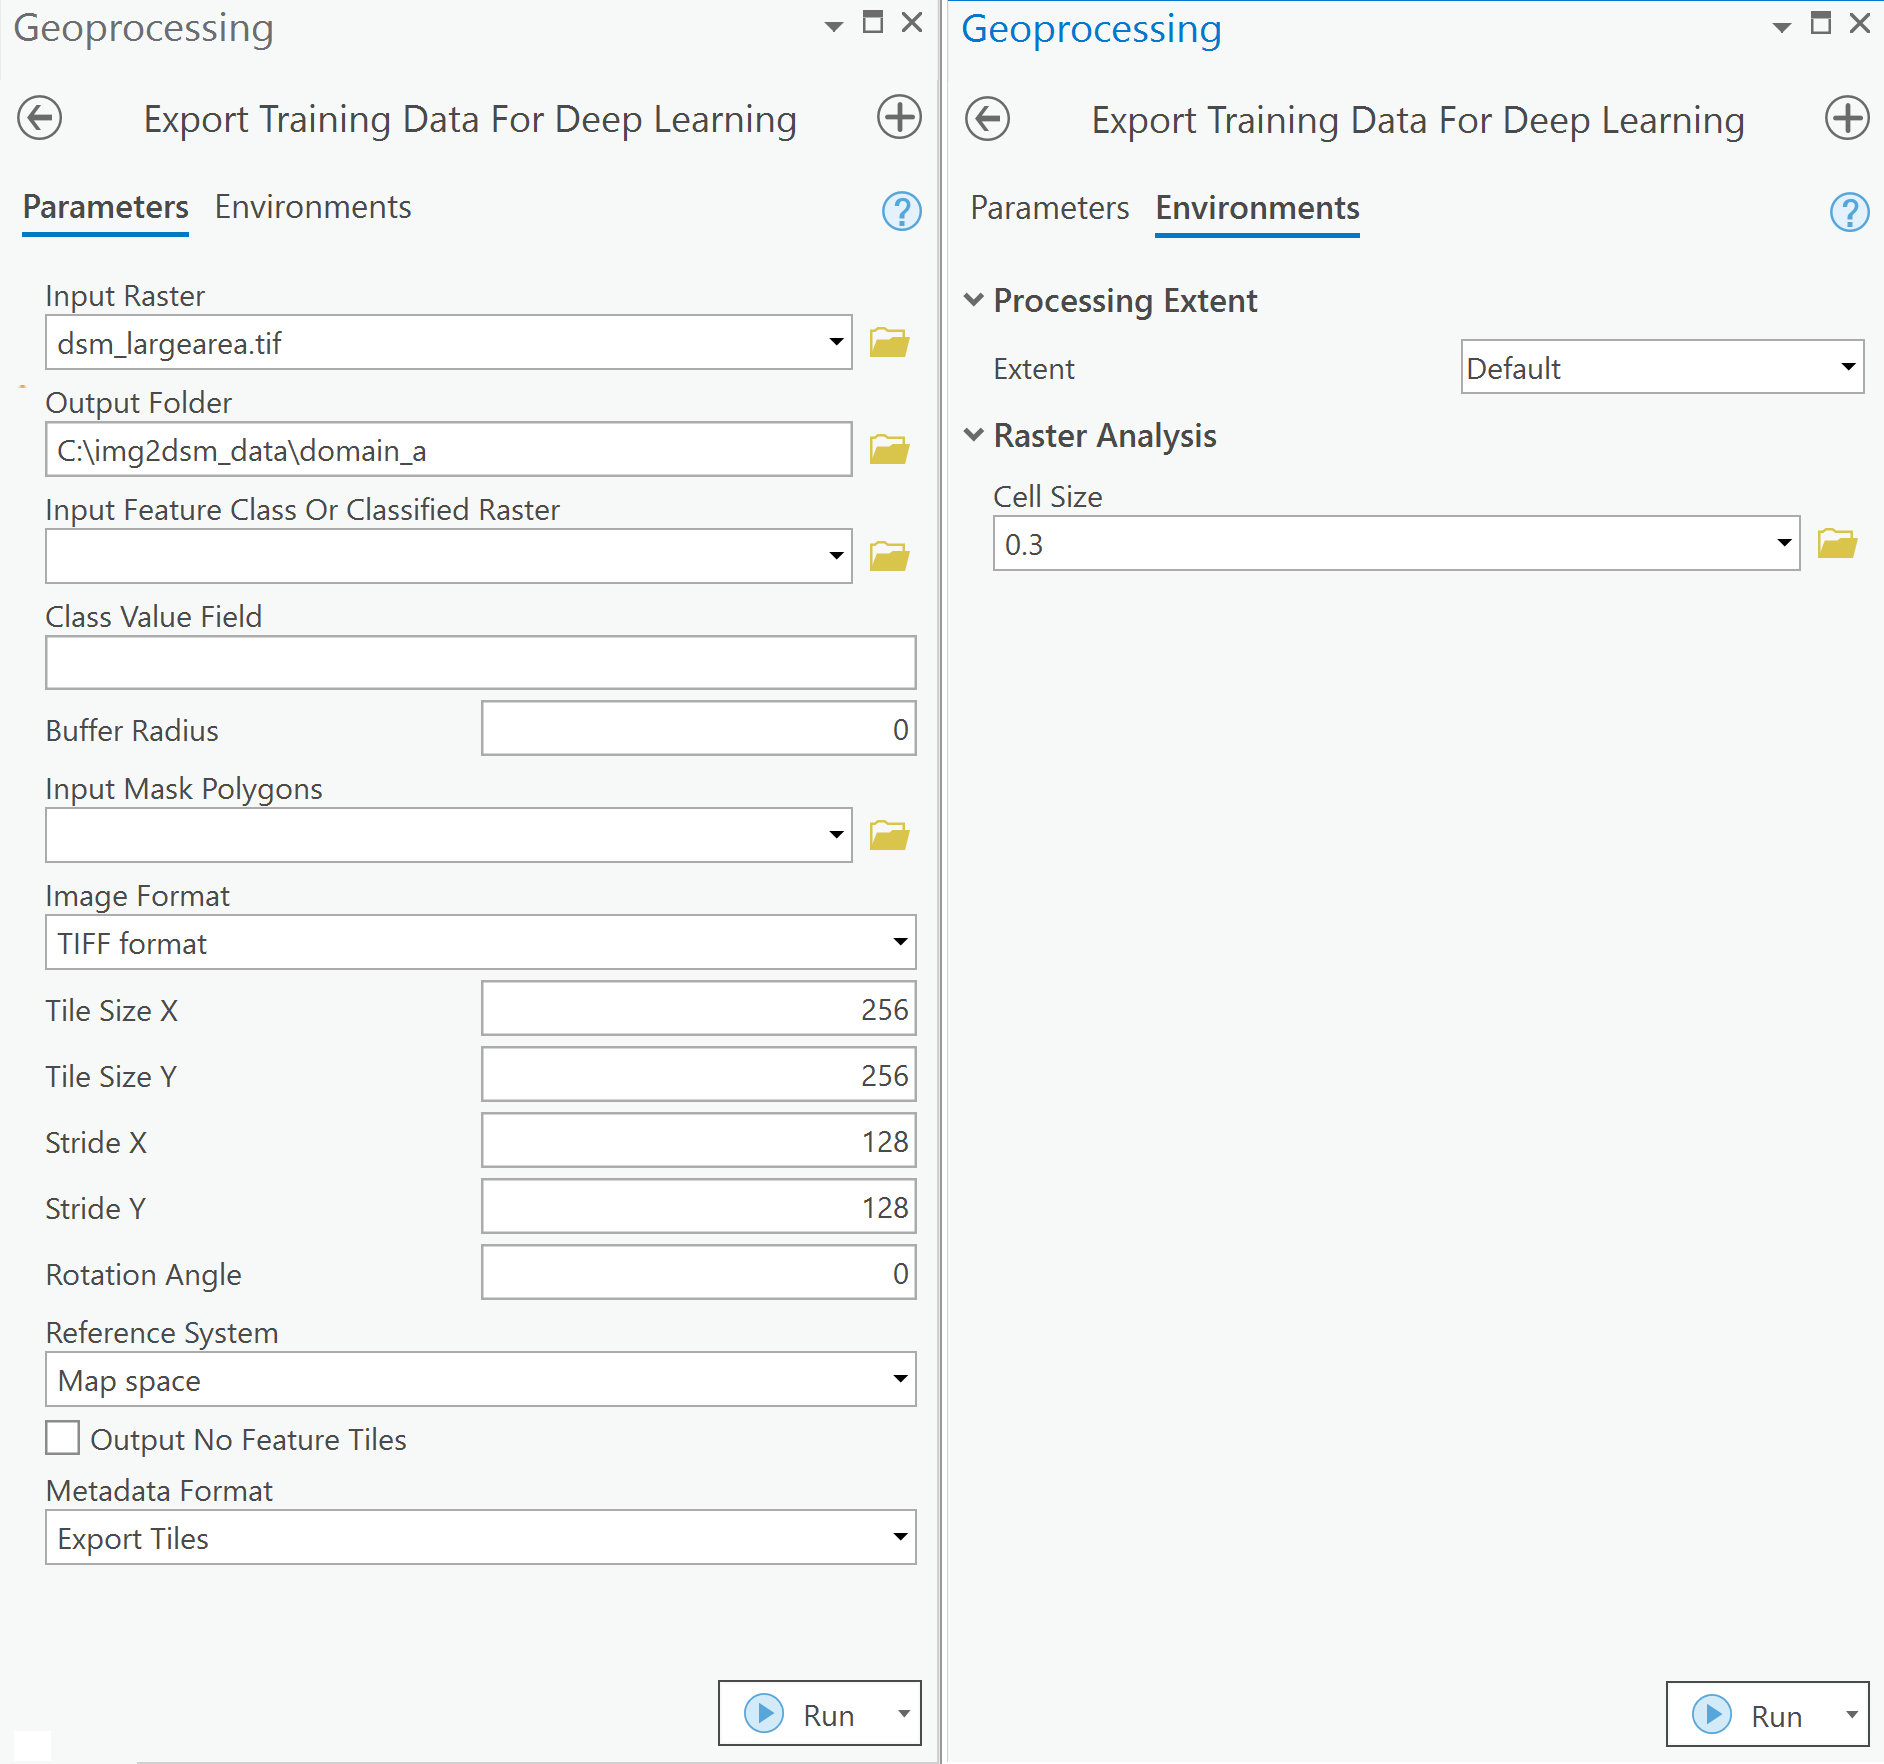

We need to run the `Export training Data for Deep Learning` again so as to get similar chips exported for RGB image also.

Once, both the imagery are exported in the required format, we need to follow the directory structure shown in figure 3 that `Pix2Pix` model follows.
<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAAAUYAAACaCAYAAADVXOEQAAAF8XRFWHRteGZpbGUAJTNDbXhmaWxlJTIwaG9zdCUzRCUyMmFwcC5kaWFncmFtcy5uZXQlMjIlMjBtb2RpZmllZCUzRCUyMjIwMjAtMTAtMTNUMTElM0EyNiUzQTQyLjE3MlolMjIlMjBhZ2VudCUzRCUyMjUuMCUyMChXaW5kb3dzJTIwTlQlMjAxMC4wJTNCJTIwV2luNjQlM0IlMjB4NjQpJTIwQXBwbGVXZWJLaXQlMkY1MzcuMzYlMjAoS0hUTUwlMkMlMjBsaWtlJTIwR2Vja28pJTIwQ2hyb21lJTJGODYuMC40MjQwLjc1JTIwU2FmYXJpJTJGNTM3LjM2JTIyJTIwZXRhZyUzRCUyMlRxSWd1R0ZUZ3lueHdVaE5lSC1TJTIyJTIwdmVyc2lvbiUzRCUyMjEzLjcuOSUyMiUyMHR5cGUlM0QlMjJkZXZpY2UlMjIlM0UlM0NkaWFncmFtJTIwaWQlM0QlMjJ3YWx3c2pXOHJ0cVhJYkZQRV9HQSUyMiUyMG5hbWUlM0QlMjJQYWdlLTElMjIlM0UzVmpMY3Bzd0ZQMGFMJTJCUEJFaTh2R3p2cFk5SnBNcDVwNDI0Nk1paWdWaUJHaUJqeTlaVkFtR0RWanRzNGNja0szYU9yMXptNlYwZ2pPRXZLOXh4bDhXY1dZam9DVmxpTzRId0V3TVJ4TFBsUlNOVWd2dXMzUU1SSnFKMDZZRUVlc0FaMXU2Z2dJYzU3am9JeEtraldCd09XcGpnUVBReHh6dFo5dHp0RyUyQjZObUtNSUdzQWdRTmRGdkpCU3hYa1c3TElWJTJGd0NTSzI1RW5scTVKVU91c2dUeEdJVnMlMkZndURGQ000NFk2SXBKZVVNVTBWZXkwdlQ3bkpIN1daaUhLZmlrQWJmbHpuJTJCT3N1WGxIM2hENkQ2ZEhOVjNadzVlbTZpYWhlTVE3bCUyQmJUSXVZaGF4Rk5HTERqM25yRWhEckhxMXBOWDVYREdXU1hBaXdaOVlpRXFMaVFyQkpCU0xoT3JhWmt3MTBNNmxhQ2huQlElMkZ3bnZtM1d3THhDSXM5Zm1CRHVOeXBtQ1ZZOEVxMjQ1Z2lRZTc3ODBCNnkwUWJ2NDVWV2RERSUyRmdYSnV0OTdSQXM5MGh3SlpEQXZjQ242UkNGS29sU1dBOGtMNWhLNHgxd1F1VG5mNllxRWhHR2pDYzdKQTFyVlhTbFZNa1pTVWElMkZET1I4NWM5V1hsQ0Z2Rk9rMFVQM2hjcjhLSm10dEE2aDN0ZzV0YUd0NzNRVktDOFdQWXFRTmlLUHo3SjVpTTB1eWVIV3Iybzh0ME5yTDJyYTkxcDZYZW9ER3FoNWIxNWdUdVg2bGJ3MGVNVHJBZ2RFQlR4a2QlMkZrbFZPNU95V1haZk4zY291dG1uMUEwWVdlMWpJayUyRkRmUGg1YmVvOG1kZWMxOHhyMDRFZjBzOU5MN3JwdGRLJTJCa3dsNlc4ZlB4TzkzMFlTUGJyVWx3V1lhJTJGNjRLTlBhJTJGNElpa1A0WiUyRnNBUGY2ek5yJTJCYWNOZ1BZeU1OZ0llRzZpUGpBQyUyRkMwQlhqZ0M3QjBSc0hwN0VlQ2QlMkJBaVltSGVJNjJZMXdLV0syaFdYcFVpVkx1VVZWekk2ZEFrbW9IOEsyJTJCQXdDZUNMU1dBbSUyRkVXeDJzViUyRmUlMkJrYnNnSlQ2MGtGM0ZkVndFdzQlMkJ4UUFnMWNBJTJCT0ElMkZVOEExRkRCSXpnVm52emFQWmFEUGR4NmpUUGtsWmFUZUM4ZDNsSzJER0hFeFRnb3F5Rm5JZ2lLcDJUbGZ4MFRnUllicWczVXR2WSUyRkRLZHphMVdCcSUyRnR6WVU1TlQlMkI4VTQ5ZDRjcDlEOXcwdlFxM0xxRzV6V2wxTUozUkg2QnU2bzBKdU90ODlIeCUyQkRjTzg0dmlqUzdaJTJCcm01N0Y3N0ljWHZ3RSUzRCUzQyUyRmRpYWdyYW0lM0UlM0MlMkZteGZpbGUlM0VWs0YDAAAZ90lEQVR4Xu2dXWhUR9jHR4pSbdWWBBQsfiHEOzUtXlSDEYp6U6OpkBYVzU2tVaKiBY3Ej0iLoEVNo2CvIlEwxfpBC9YbjRjvih8UoQGJiUVawVCtVqGt+vKf9332nRz37M45ez73/AeW3ezO53/m/PLMPHPmDHv58uVLxUAFqAAV8KHAjRs31OXLl9XDhw99pA4/ycyZM9W8efPUW2+95amwYQSjJ70YmQpQgf9TYPfu3WrXrl2J12Py5MnqzJkzCpC0DQSjrVKMRwWoQE6B7u5uNX/+fP33hg0bPFtkUUmJesKiBRSvX79uXSzBaC0VI1IBKiAKzJ07V129elWtX79eLVu2LFHCzJgxYwioYTEODAyoS5cuqdraWqu6EoxWMjESFaACUABriUuXLlWwxJIcsKaI6TNAiOk+pv07d+60nvoTjEnuXdaNCiRMgSlTpqj+/n41duxYT2t2UTYDU2cJd+7cUR0dHQRjlB3AsqhAlhQ4ePCg2rRpk8JUFRajV09vVFrBql2yZIleW4SViECLMSr1WQ4VyJACZ8+e1U6Wu3fvqunTp6vx48cnrvWYNosjSCC+atUqhTVGgjFx3cUKUYF0K4CpaGNjYyoaId5n8ZpjDyOASTCmovtYSSqQDgWwnjhr1iztdDlw4EBi1xWh5saNG9XNmzf19BkwxHYigjEd44y1pAKpUgBTaHih6+rqFD4nOUhdAUN4ognGJPcW60YFUqyAn60ucTZ32LBh2imErToEY5w9wbKpQBkrkEYwojuwmZtgLOOByaZRgTgVIBjjVJ9lUwEqkEgFCMZEdgsrRQWoQJwKEIxxqs+yM6HA7du31bRp0zLR1nJpJMFYLj3JdiRSgVu3bqkFCxaoDz74QLW0tHgG5J49e9TUqVPV8uXLrdv37NkzfQvbypUr1Zw5c6zTJT3i119/rT799FM1evTo0KtKMIYuMQvIugLYD/fjjz8qbKkArLZt22YNSD9gLFe9R44cqZ4/f642b96smpubQwUkwViuo4jtSowCsBqrq6vVP//8o15//XV9cdsA8sSJE2rFihW6HcePH1d9fX0KeXV1dem/6+vrtWV49OhRHWfNmjX6Lg0EsRjxub29XX938uRJfRAC0ldVVRXUZ3BwUFupFy5c0PFaW1u1xRtnOHTokNq6dat68eKF/ieDNoYFSIIxzp5m2alSYMuWLerx48e+6vzDDz+o33//PZcWgPz333/Vhx9+qDflugXTYsTne/fuafjBesLfCACWgAyfAWETjDhctaenJ/f9hAkTCkJOpuI1NTUajr29vaqpqUm1tbUVBaovcTwkqqys1G1FGDFiRGiAJBg9dAqjZlsBWClinXlVYu/evQpn5EkA2N544w19n+v27dutwSggdCYw1xWdYARAYX1WVFTod1ieXqw/gAgnVgMWbpZmnM9BGT58uFq8eLE6deqU125xjU8wBiYlMyp3BQBGPw+XvHjxop72Pnr0SFt6cB7gwlu7dm1RyZwWo+mIgSXX0NCgDxCQYFqGmK4jdHZ25qxMWzDi+H5YmhJsp+BFG1RiBFqM+QXE2ETgnS8lDjAm966AXzC+++676pdfflFvv/22NRCldm5gdE53C1mMXsFoTsvh1baxGL2r6T0F1hjhuMIaLdcYh+pHMHofT0wRkAJ+wPjff/+p999/X5/rZ2MhOqtqC0ax8IKwGJ1ghJW5b98+K6dNQFLnzYZeaXd1CcYwRx7zLqiAHzCWKql4psUrbU6lzekuvMYI+F281aVMpU2PONZVr127Fvu+SO5jJBhLvZ6YPgQF4gBjCM1glhYK0PliIRKjUAEoUE5gxBR9x44deTsW0/FyumPGz+glGP2oxjSZVKCcwJjJDvTQaILRg1iMmm0FCMbs9H/awYhDS2D1Hzt2TD8LBu2xCcNe+tmQZpMz45StAgRj2XbtKw1LOxjNBhGM2Rm3sbSUYIxF9lgKTTsYx40bp+7fv6+1IxhjGULZKZRgzE5fpx2MeGIgnh548OBB/ZAs3HpqEziVtlGJcYYoQDBmZ0CkFYyAIJ6FDTB2d3d77jCC0bNkTEAwZmcMxAHGy5cva4EFaPJeW1urv5d3QM8Z5M4X+Z5gzM5Yjb2lBGPsXRBZBaIC47lz51RHR4ee9noJgOTq1atVXV2dnioLGHGEHfKD1UiL0YuijOtbAYLRt3SpSxgmGG/cuKG30QjARBycYATIzZw5c8i704IUyxLpEH/JkiU6LwTZbNPf368mT57sWXdOpT1LxgQEY3bGgIARkMJnWGalBFhwsA7hDAEYTRjC8sMLkLMJyAsWJmBoQtIEo00++eIQjH6Vy3A6gjE7nQ/o4EQkCYAW4LVhwwZPlhhgKBCTvMaOHavzwgvgLSXAMgRsUcbAwICv80LN8gnGUnojo2kJxmx1PCwzABIv8zBgTFHzvWAJIo3zXVSD1YlpL4AYRkA9S82bYAyjZ8o8T4KxzDu4QPMAO4EkTmK3DZMmTdJ7CAFEP2t+tuUEFY9gDErJDOVDMGaosws0FdPXfC+n00T+TpNqBGOaeishdSUYE9IRrEZoChCMoUlbvhkTjOXbt2zZ/ypAMHIkeFaAYPQsGROkTAGCMWUdloTqEoxJ6AXWIUwFCMYw1S3TvAnGMu1YNiunAMHIweBZAYLRs2RMkDIFCMaUdVgSqkswJqEXWIcwFfAFxt7eXtXQ0DBkFzxu/O7q6lJVVVVF62s+PL1o5JAi+H02L9qOe0bb29tVRUVFSLVLdrYEY7L7h7UrXQHfYGxqalJtbW05EOKh5+vWrbOCYxLAOHLkSPX8+XO1efNm1dzcrEaPHm2lJsFYXo9Ptep0RsqcAoGBEcoBeAgtLS3q2bNnatOmTero0aP6uzVr1qgDBw6o06dPqxUrVujvjh8/rurr6/PGA7jCDIcOHVJbt25VL1680Ge4oa42gDTBOGrUKJ2uurpaHTlyRFvQaFNfX59+VvHChQvViRMntGU5ODioli9fri5cuKCb1draqnVCQBxoAqt7wYIFGtLym/ncY+SNPBDwj2ju3Ln6s1lOmJpJ3rQYo1CZZcSpQKBgxMXa2dmpAbh///4cJAUKuNjxKEPTYjRh6owXtjCVlZUaWAgjRoywAmQ+MCI92nzt2jUNKxP4NTU1OfjjM8CGPMTiRlr5jPrgd2gErQDMK1eu6Lzv3r2rly8OHz6spk+frtavX6+n9Fi6QDwEgWbYuhGMYSvM/ONWIDQwmhafWI8rV658BYymAM54buLs3r3b+vmwXgUePny4Wrx4sTp16lTepPnAaALPXH90WzIAjAVsP//8s7YwTesRf2/ZskVbo5I3KiP5LVq0aAgYC7Vx/vz5vk4wLpQnjp76888/vUrL+FQgNQoECsZ8Fo55TFFPT88rYMznyJF4YasYlMUowHeuP5pgNKe+aJc4q7777rucZY0P0NAEoyxFiBYyBTd1k2WKsJcfOJUOe0Qy/6QoECgYZVrstHbcLEZZXxSryNZiDEI8rDFu27ZNO2BKXWMsBkZYeJjmylKCF4tR8i7UZoGpWJ1B6FMoD06lw1aY+cetQGBgNL3SEydOHDINFGvJaTE6weiMF6Y4QXilxfniFYwA2b59+7QHH8FmjfHp06carijrvffeG7JliGuMYY4U5p1FBXyDsdg+RnPqiOkfwtSpU/XFLV5YOClwaKV4V53xwuyQIPYx2oLRbDPahOkxHDUCVNED3mW8njx5ktcrnc+Tjfw4lQ5zpDDvLCrgC4xZFCqKNstSgulwiaJcr2VwKu1VMcZPmwIEY8w95nTKmFZhzFVzLZ5gTGrPsF5BKUAwBqVkhvIhGDPU2RltKsGY0Y4vpdkEYynqMW0aFCAY09BLCasjwZiwDomxOnhqIB52j8elJjHgQVzz5s1TuCnBSyAYvajFuFoBgpEDAQqEeQdakApj58uZM2cUIGkbCEZbpRgvpwDByMHQ3d2tcLspwoYNGzxbZFEpiHrCogUUr1+/bl0swWgtFSOKAgQjxwL2HmNHBe75X7ZsWaIEwe225tQZFuPAwIC6dOmSqq2ttaorwWglEyOZChCM2R0PWEtcunRp4AeTBK0owIjpM0CIg10w7d+5c6f14TMEY9A9koH8CMYMdLJLE6dMmaL6+/v1r3BqJDHAIfTo0SNdtTt37qiOjg6CMYkdVW51IhjLrUft2nPw4EF9BgKAePbs2cSuK8KqhaWIk71gJSLQYrTrY8YqQQGCsQTxUpoUIISTBQcmT5s2Tb3zzjuJawlgKI4gWImNjY1q1apV+jwGgjFx3VV+FSIYy69PC7VIIJOGVov3WbzmsG4BTIIxDb2X8joSjCnvQA/Vx3rirFmz9AZuPGLDy15AD8UEEnXjxo256TNgiO1EBGMg0jITGwUIRhuVyiMOptDwQtfV1el1xSQHqStgCE80wZjk3irDuhGMZdipLk3ys9UlTnUwNmWrDsEYZ09ksGyCMTudnkYwonewmZtgzM44TURLCcZEdEMklSAYI5GZhZSDAgRjOfSiXRsIRjudGIsK8HSdDI0BgjFDnc2mlqYALcbS9EtTaoIxTb3FusaqQBxgxDPL5SmTto0v9Tnlpaa3rafXeH6fcOm1HMQnGP2oxjSZVCAtYCy1c5IKRr/PRPejB8HoRzWmyaQCUYNRnrsNsfEs8r6+PnXr1i3V1dWl/66vr9eHG+B53QjynG18xvd4fjdCe3u7fj958qTCmX1IX1VV5dqHAsbq6mp15MgRfVcFysNzwuMMhw4dUlu3blUvXrzQ671oY3Nzsxo9enTg1SIYA5eUGZarAn7A+Pjx45IuXHMqjc/37t3Tt6jBesLfCC0tLWpwcFCDC58BNBOMOFy1p6cn9/2ECRN0PLcgYMRtcYDzgwcPVFNTk2praysI1Cj6vbKyUrcVYcSIEaEBkmCMojdZRlko4BWM58+fVx999JE++cSvZeMEo4DQKag5/XWCEXkAcBUVFfodlqcNGGtqanJWYrG1zjifgzJ8+HC1ePFiderUqcDGGcEYmJTMqNwV8ApG6AHHyW+//aZee+01X1M/JxhNR0xvb69qaGjQU10JpmUoU+nOzs6clekFjEg/Z84cnXUxMEbV97QY8yuNsYnAO1+iGoksJ6eAHzBiXe+zzz7TJyv7mfq5gVEsRLHqClmMfsHozNu0IOMYFlhj3LZtm3r+/HloU2hpFy3GOHqYZaZSgTFjxqhPPvnEc91hpf3999+5dAAkHAh79+5VmzdvLpifLRjxgCbnWmKpFiMqhvVMHNKahDVGeqXdhwotRs+XJRMEpcC3337rKyuclweLTgIAO27cOA1GeJYLBfFMi1fanEoLDJG+tbVVZ4PfxVtdKhhNrzSm6DKt9iVCAIm4j5FgDGAYMYskKIDnhWzfvl09ffpUAYgTJ07UpyoXA2IS6p7lOnAqneXeZ9tDVwB77F6+fKnwlLkkARFT9B07duRtfxKsw9A7pkgBBGPcPcDyy1YB7DmcPXu2+uabb2ghpqyXCcaUdRirSwWoQPgKpB2MeKIh1oSPHTumH6WK9tiEYS8xv2GgAlSACuRRIO1gNJtEMHKIUwEqEIgCaQcjdj3cv39fa0EwBjIkmAkVoAJpByOeGIinB2JXBB6ShS1jNoFTaRuVGIcKZFSBtIIREMSzsAHG7u5uz71HMHqWjAmoQHYUiAOMly9f1gIL0OS9trZWfy/vgJ4zyJ0v8j3BmJ2xypZSgcgUiAqM586dUx0dHXra6yUAkqtXr1Z1dXV6qixgPHPmjM4PViMtRi+KMi4VoAJFFQgTjDdu3NDbaARgUhkcIgzIzZw5c8i704IUyxLpEH/JkiU6LwTZbIOzNCdPnly0na9Yntyu41kzJqACmVFAwAhI4TMss1ICLDhYh3CGAIwmDGH54QXI2QTkBQsTMDQhaYLRJp98cbjG6Fc5pqMCGVAA0GlsbMy1FNACvHDosBdLDDAUiElmY8eO1XnhBfCWEmAZArYoY2BgIGcx+s2TYPSrHNNRgYwoAMsMgMTLPAwYYMz3giWINM53kQtWJ6a9AGIYAfUsNW+CMYyeYZ5UoEwVAOwEkjh02DZMmjRJ7yEEEL1Ymrb5Bx2PYAxaUeZHBTKiAKav+V5Op4n8nSZZCMY09RbrSgWoQCQKEIyRyMxCqAAVSJMCBGOaeot1pQJUIBIFCMZIZGYhVIAKpEkBgjFNvcW6UgEqEIkCBGMkMrMQKkAF0qQAwZim3mJdqQAViEQBgjESmVkIFaACaVKAYExTb7GuVIAKRKIAwRiJzCyEClCBNClAMKapt1hXKkAFIlGAYIxEZhZCBahAmhQgGNPUW6wrFaACkShAMEYiMwuhAlQgTQoQjGnqLdaVClCBSBQgGCORmYVQASqQJgUIxjT1FutKBahAJAoQjJHIzEKoABVIkwIEY5p6i3WlAlQgEgUIxkhkZiFUgAqkSQGCMU29xbpSASoQiQIEYyQysxAqQAXSpADBmKbeYl2pABWIRIGiYOzt7VUNDQ3q5s2bQyp0/PhxtXz58tArifJ37dql2tvbVUVFRejlBVWAU7c1a9aoAwcOqJEjRxYsYs+ePWrq1KmRaBtUW5OQD/VOQi+UTx2swNjU1KTa2tpUVVWVbvng4KBav369BpZ8F5YkaQSjXKSHDx9Wc+bM0dIAePfu3SsKR4LR+0ii3t41Y4rCCvgC47Nnz9SmTZvUypUr9YV/4sQJtWLFCl3SjBkzVFdXlwYmLvJbt27pv8XCxHc7duzQceU7yW/ChAm531pbW9Xnn3+uLacLFy6ohQsX6nLSYDVevXpVt92sLy5e+Qfz4MED1dnZmYMk4vX19amWlhad7s0339Rtxgs64HsGdwWoN0dH0Ar4AqPzIjchgM8IcpGbVhIAcOXKFQ2Eu3fv6ik6rKrq6moNWgT8du3aNbVu3ToNVIS0TaVhUQPof/zxR+6fhNlxuJALgfH777/X6SorK3U+0FIsz6AHQDnkR73LoReT1QYrMOZbY+zp6cl7sTqtH4GkWIU1NTW59TOZNtbX12swym/mVD2NYJQudrOki4FRNMO7qWeyhk7yakO9k9cnaa2RFRida4xmYwV4R48ezX0t0z9zvSxfPCRA3C1btgyZmpcLGJ1WoljWv/76a0GL0XS+EIz+Li1zek29/WmY5VQlg9GcHsPj6rQY5SJ3rkvmg6usWaYdjNAAwfTam21yrjE6lx9Mi9H8LcsDtVDbqTdHRtAKBArGp0+fahhgPUzWGJ3Wj6wxSlzAUKbS5QJGcw1WvPa4eLGuiHdYMLKGKuuIpmawdsyLnWuMhYc99Q4aC8lcwsF1MXfuXO3gnTdvnpo9e/Yr7AhKiZLBKAvf4jleu3atOn/+vHai7N+//5U9eaZXWqbcTmvStK4EHLLelgavNOrq3Ffn9KqLDvgerydPnuT1Ske1XzSoARVXPtQ7WOWTuISTb2ZQaCZaiiJFwVhK5kxLBahAOhUwwSjOwjFjxqh9+/bpf+SYxWDWgxs/zH/ebg4w08fw8ccfa1GwFxozJaf/IZ9j18wXBhUCZqPO2aZYlfjdvKnC/Mdpbil06x2CMZ3jlrWmAqEq4AQjprAAlmyt6+/vzy0LmU5Ft617pi8C2/EkP4DRXEcH2GSZyXnzSD7/hQlGzC7FUTxx4kTt0MXeaKdzF2VcvHix4P5ggjHU4cXMqUA6FXCC0Qk88R0UujNN8nCCyZz+Tp8+fche3UJT42JgBKzFhwFHsFi6X331lWpubs7dkGLTIwSjjUqMQwUypkC+qbTc629uwzPBOGrUKG2lObfuyR1s4kTMB0b4KMyQb23dBoxyB57kJWv7+NvLXXQEY8YGPJtLBWwU8APGn376aYjFZmsx2p67YANGubW2UBudN1jki2sFRnPh08zE7e4XieN2IIJ4stO0DcX0pkv7ii3iFpsWmGa/zWAtFCeNh20Uak9S9TYX91H/YtdAqf0aV/pSwejcume7xpjvQBDRoBgYzTVGOasBtySDM5jOy6E3ga0xOjdx23ZWuYER7fZyoENUYJTBNH78+NQctFFsDPnZ2B623viHvn37dvXll1/qw0zyHV5RrF1p+d0PGJ3TVXPrHn6TafYXX3yh/vrrr9yan9Mr7bZFrRgY4cgx/3GZW+TcvnfrD2uLsZB14+Yid7slEG50LJSKxVgovfN0nrgGVrELtdCpQbJx3dygumDBAj04zHUbt1OHHj58qA+VyGediBdv9+7d6uTJk6k7t9KtP5Oqt1nfNM584rp+zHLzbchPQr3MOpQMRtP0FVc+XOTOO1/M8whNd72biz3f6TxxilfoQjXvasHtfs5TgwBGtNPtNKHTp08XPHVI9MzaVNrNQk+C3qhbGi7wOK8Zs2zn0kjSlyCswej09oi561zINKcXR44cybsJ05zyuLnY5c4Zr9PXsAZCvjUv6VznkoFA1NymgHqZR405txLYnDqUNTCKBS3tTpLe+U6LCmvsMd/oFbAGo9tU2rn+aDoBBIyLFi1y3asEMLq52CV9FI9QKCa9m8WY7wLJ540rtsfK3OKAuuQ7dajQOkk5Ol/y/VNMgt7mwcpe1pyLjTH+nhwFSgZjEBajm4vdzXkTh3yFptJBWIyyDmm2zct9oFkBI/SJU29ZV0R/JeEfdhzXQhbKLBmMtmuMbu56Nxe72yEUcXVKqWuM5g5/54nl5hpjoVOHsjaVLmWNMQy9OX2O6+qLvtySwYgq+/FK44b0uro6fRO52xQxLRajWDFuXmWnVxrxMXW+ffu2gjcZty/ZnDpEMP6/Al52AQSlt9sTM5PuSIgeK+kv0QqM6W8mW0AFqAAVsFeAYLTXijGpABXIiAIEY0Y6ms2kAlTAXgGC0V4rxqQCVCAjCvwPgmOmjAm+BmUAAAAASUVORK5CYII=">
<br>
<center>Figure 3. Directory structure</center>

Here, 'train_a' and 'train_b' folders contain all the image tiles from two domains (excluding other files like 'esri_accumulated_stats.json', 'esri_model_definition.emd', 'map.txt', 'stats.txt') exported from DSM and drone imagery respectively. Now we are ready to train the `Pix2Pix` model.

## Model training

Alternatively, we have provided a subset of training data containing a few samples that follows the same directory structure mentioned above and also provided the rasters used for exporting the training dataset. You can use the data directly to run the experiments.

<Item title:"data_for_pix2pix_with_trained_model" type:Image Collection owner:api_data_owner>
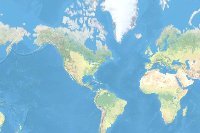

In [3]:
training_data = gis.content.get('2a3dad36569b48ed99858e8579611a80')
training_data

In [ ]:
filepath = training_data.download(file_name=training_data.name)

In [ ]:
#Extract the data from the zipped image collection

with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

### Prepare data

In [2]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [3]:
data = prepare_data(output_path, dataset_type="Pix2Pix", batch_size=5)

### Visualize a few samples from your training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualize them. On the left are some DSM's (digital surface model) with the corresponding RGB imageries of various locations on the right.

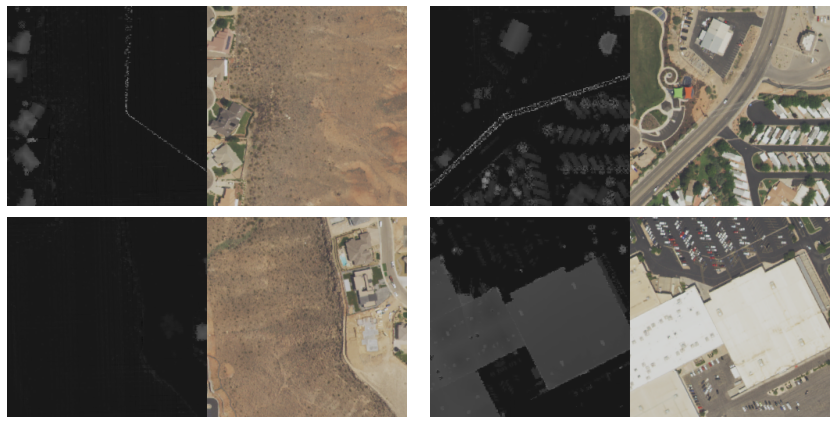

In [4]:
data.show_batch()

### Load Pix2Pix model architecture

In [4]:
model = Pix2Pix(data)

### Tuning for optimal learning rate

Learning rate is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

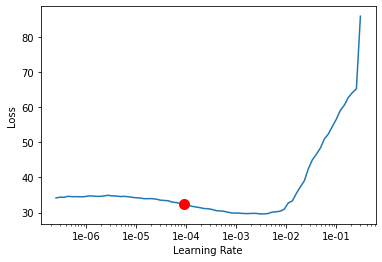

In [5]:
lr = model.lr_find()

2.5118864315095795e-05

### Fit the model

The model is trained for around a few epochs with the suggested learning rate.

In [8]:
model.fit(30, lr)

epoch,train_loss,valid_loss,gen_loss,l1_loss,D_loss,time
0,13.203547,13.980255,0.576110,0.126274,0.412447,01:01
1,12.675353,13.891787,0.573363,0.121020,0.411131,01:02
2,12.830377,13.652339,0.577334,0.122530,0.410224,01:00
3,12.826028,13.478950,0.578673,0.122474,0.410028,01:01
4,12.830496,13.464501,0.579446,0.122510,0.407034,01:01
5,12.978190,13.808777,0.581329,0.123969,0.405155,01:01
6,12.933887,14.188525,0.579817,0.123541,0.402280,01:01
7,12.660383,13.273459,0.583129,0.120773,0.398041,01:01
8,12.493378,13.234705,0.584513,0.119089,0.395928,01:02
9,12.704373,14.314936,0.583671,0.121207,0.393755,01:01


Here, with 30 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to translate between domain of imageries.

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. 

We will use the save() method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
model.save("pix2pix_model_e30", publish =True)

### Visualize results in validation set

It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

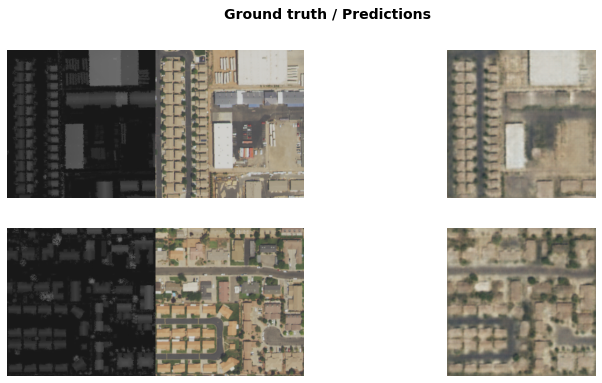

In [10]:
model.show_results()

### Compute evaluation metrics

The Frechet Inception Distance score, or FID for short, is a metric that calculates the distance between feature vectors calculated for real and generated images. Lower scores indicate the two groups of images are more similar, or have more similar statistics, with a perfect score being 0.0 indicating that the two groups of images are identical.

In [11]:
model.compute_metrics()

263.63128885232044

## Model inferencing

### Inference on a single imagery chip

We can translate DSM to RGB imagery with the help of predict() method. 

Using predict function, we can apply the trained model on the image chip kept for validation, which we want to translate. 

- `img_path`: path to the image file.

In [6]:
valid_data = gis.content.get('f682b16bcc6d40419a775ea2cad8f861')
valid_data

<Item title:"dsm raster chip for inferencing" type:Image owner:api_data_owner>

In [6]:
filepath2 = valid_data.download(file_name=valid_data.name)

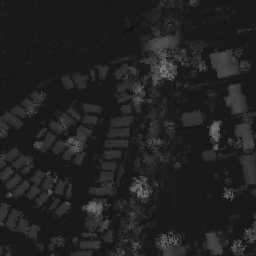

In [7]:
# Visualize the image chip used for inferencing 
from fastai.vision import open_image
open_image(filepath2)

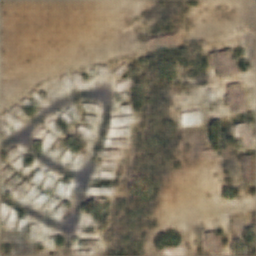

In [14]:
#Inference single imagery chip
model.predict(filepath2)

### Generate raster using classify pixels using deep learning tool

After we trained the `Pix2Pix` model and saved the weights for translating image and we could use the `classify pixels using deep learning` tool avialable in both `ArcGIS pro` and `ArcGIS Enterprise` for inferencing at scale. 

In [5]:
test_data = ent_gis.content.get('86bed58f977c4c0aa39053d93141cdb1')
test_data

<Item title:"dsm_test_area_tif" type:Imagery Layer owner:api_data_owner>

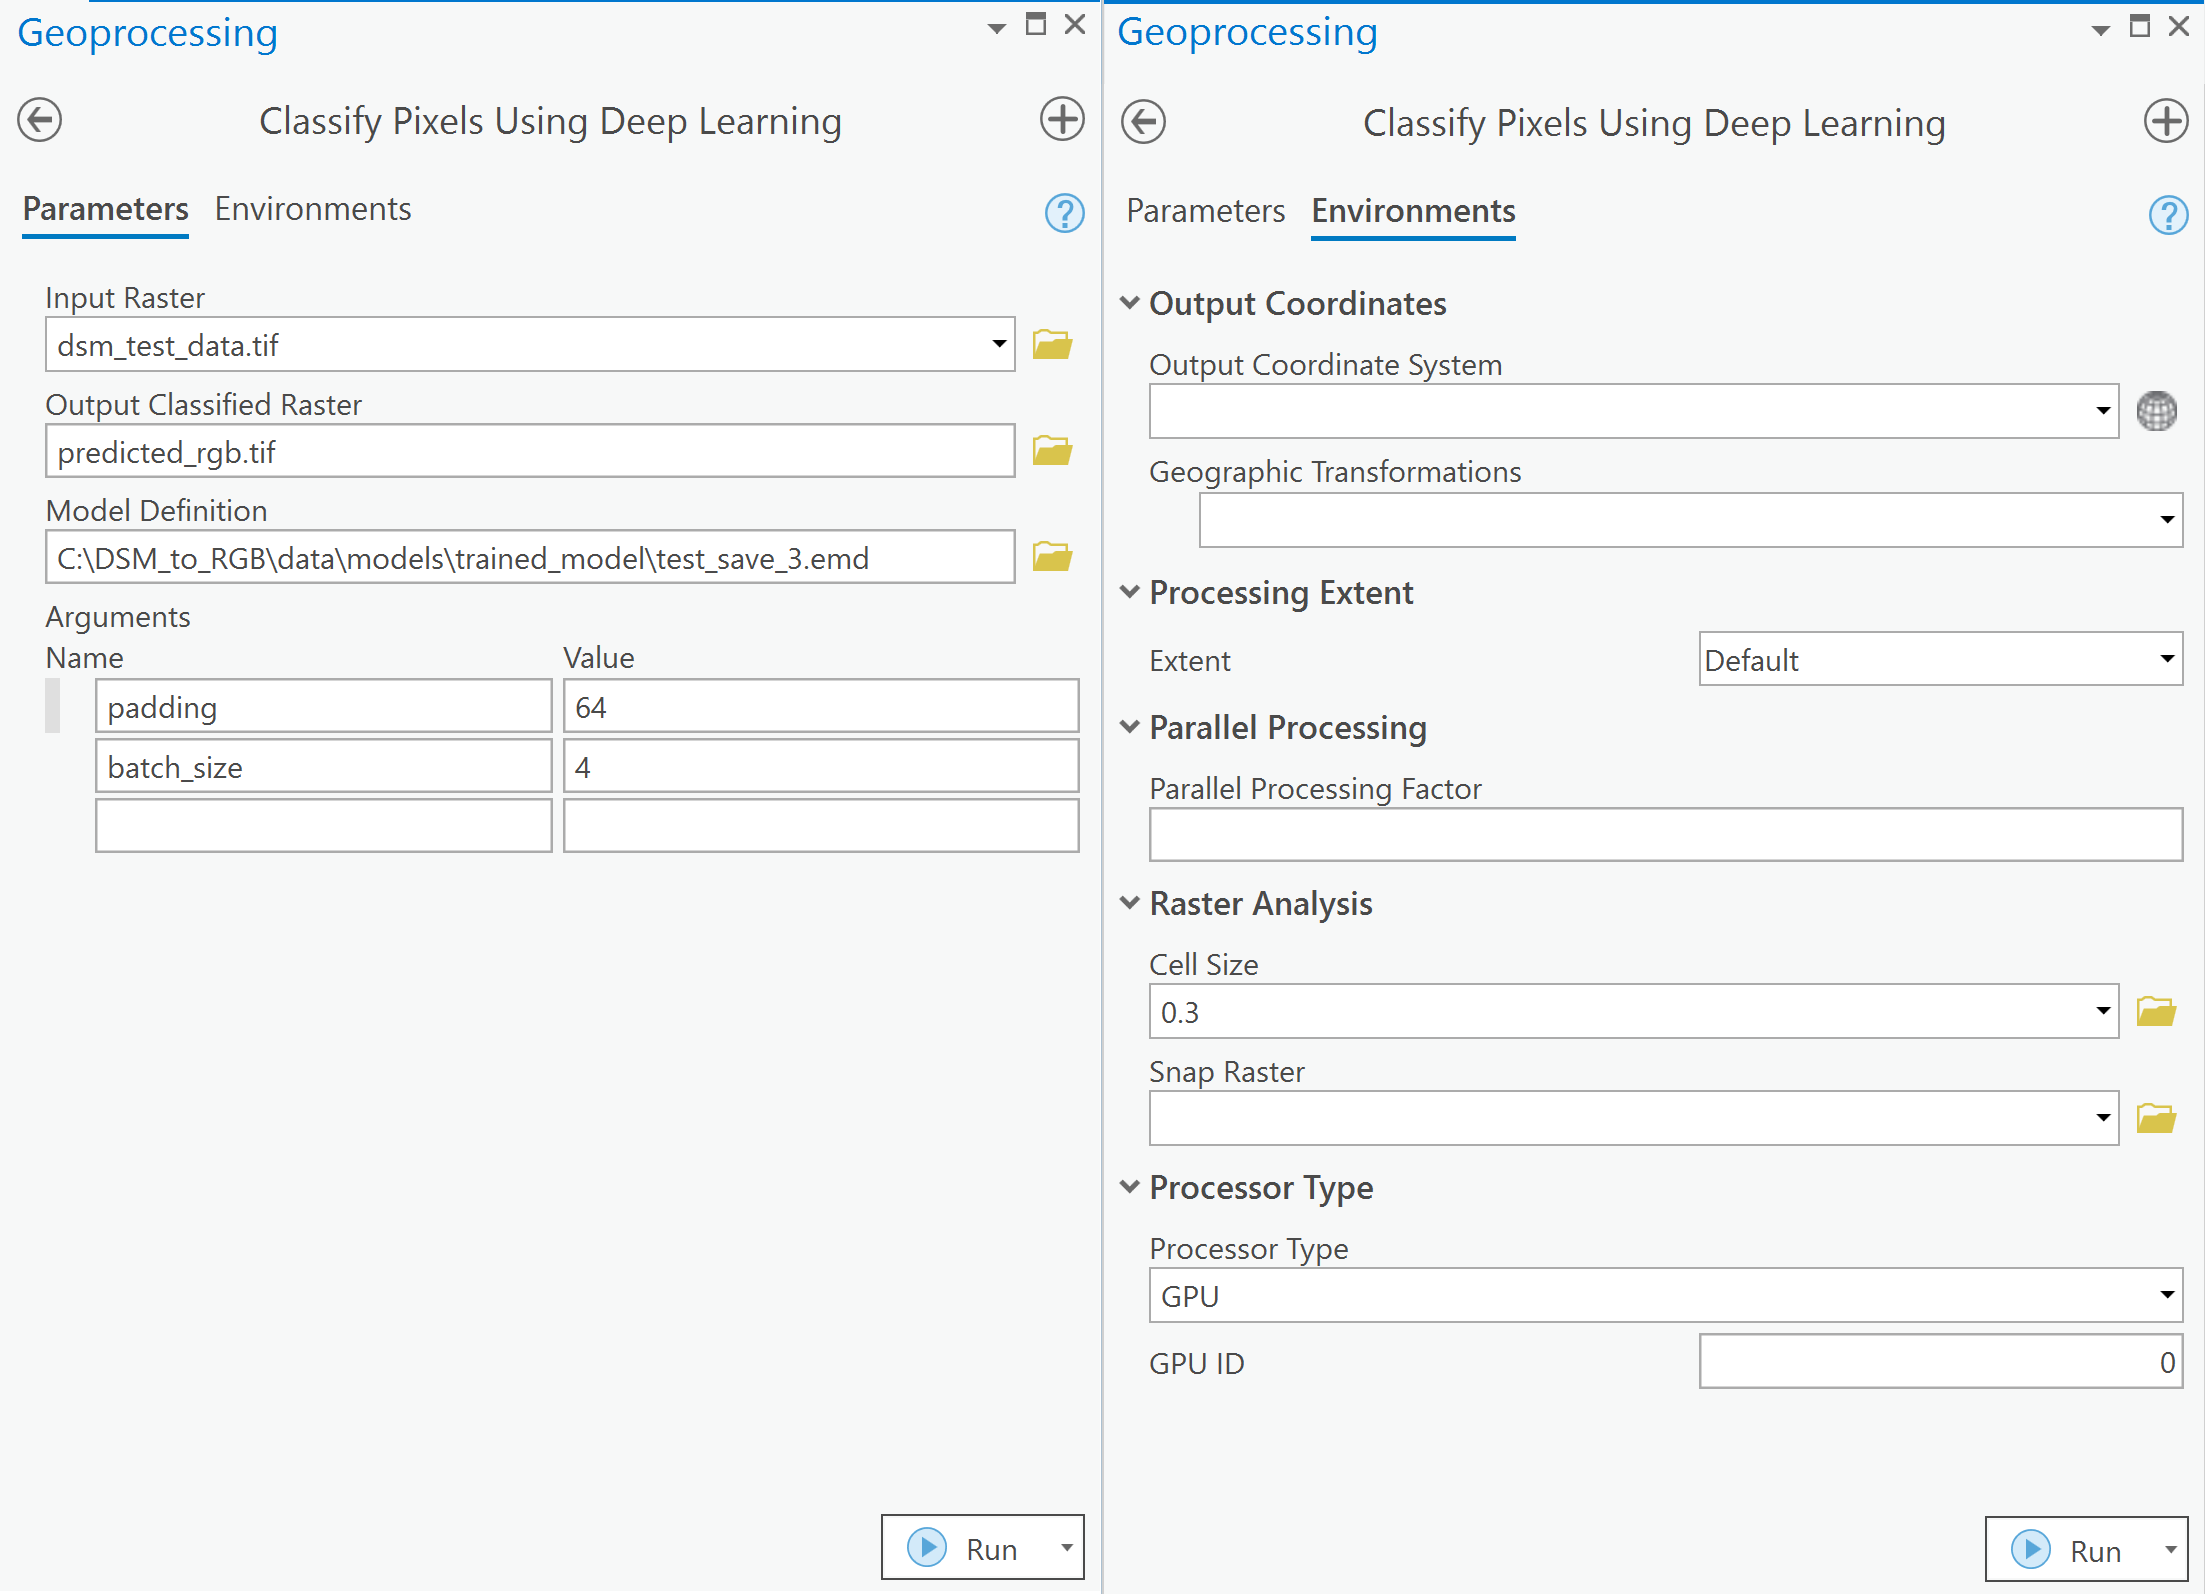

`out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("Imagery", r"C:\path\to\model.emd", "padding 64;batch_size 2"); 
out_classified_raster.save(r"C:\sample\sample.gdb\predicted_img2dsm")`

Output of this tool will result in an RGB raster generated from provided DSM as shown below. The predictions are provided as a map for better visualization.

https://pythonapi.playground.esri.com/portal/home/webmap/viewer.html?webmap=dcb449ad54d44b519cc6dec8b0886589&amp;extent=-113.5676,37.0881,-113.4664,37.1299

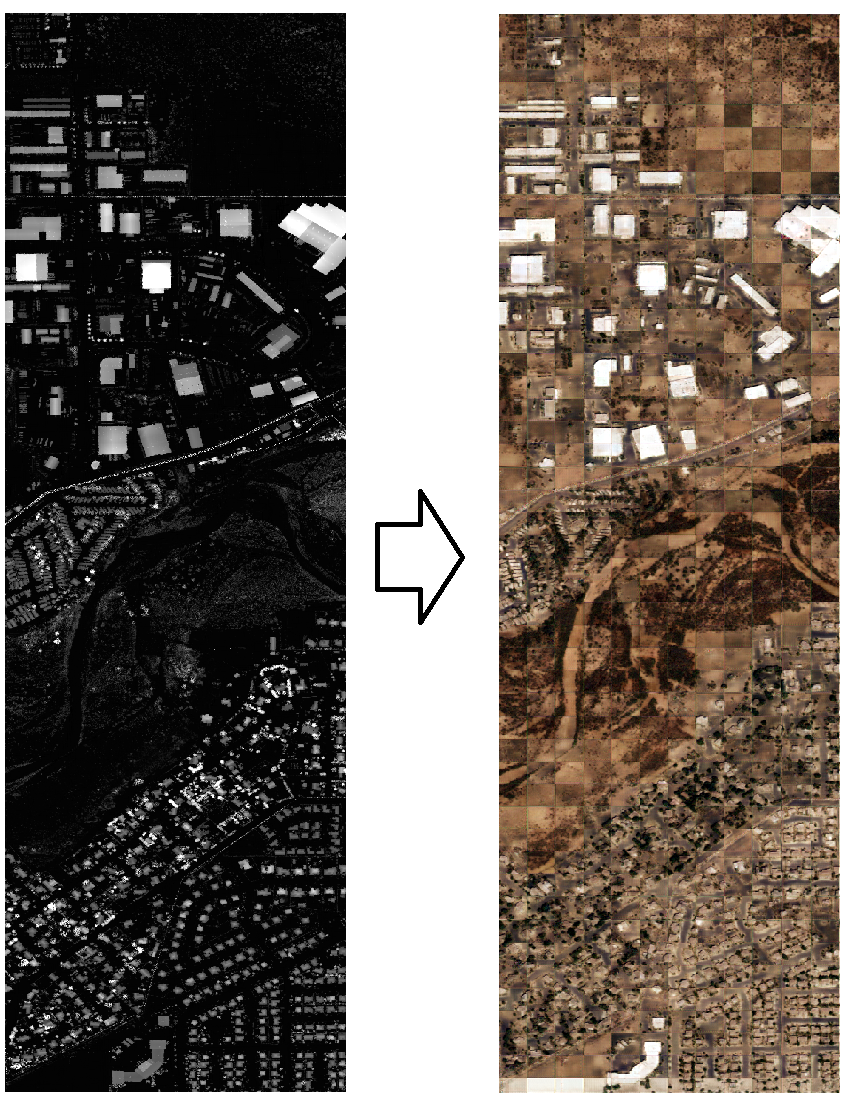

## Conclusion

In this notebook, we demonstrated how to use `Pix2Pix` model using `ArcGIS API for Python` in order to translate imagery of one domain to the another domain.

## References

- [1]. Isola, Phillip, Jun-Yan Zhu, Tinghui Zhou, and Alexei A. Efros. "Image-to-image translation with conditional adversarial networks." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 1125-1134. 2017.
- [2]. Goodfellow, Ian, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. "Generative adversarial nets." In Advances in neural information processing systems, pp. 2672-2680. 2014.
- [3]. https://stephan-osterburg.gitbook.io/coding/coding/ml-dl/tensorfow/chapter-4-conditional-generative-adversarial-network/acgan-architectural-design
- [4]. Kang, Yuhao, Song Gao, and Robert E. Roth. "Transferring multiscale map styles using generative adversarial networks." International Journal of Cartography 5, no. 2-3 (2019): 115-141.
- [5]. State of Utah and Partners, 2019, Regional Utah high-resolution lidar data 2015 - 2017: Collected by Quantum Spatial, Inc., Digital Mapping, Inc., and Aero-Graphics, Inc. and distributed by OpenTopography, https://doi.org/10.5069/G9RV0KSQ. Accessed: 2020-12-08